David Fleming 2016

University of Washington

# CBP Migration Snapshot Analysis Pipeline

This script searches for and reads in all snapshots in the CWD, analyzes them, and stores/processes arrays of quantities on interest.

In [1]:
#Imports
%matplotlib inline

#Imports
import pynbody
import matplotlib as mpl
SimArray = pynbody.array.SimArray
import matplotlib.pyplot as plt
import pynbody.plot.sph as sph
import numpy as np
import matplotlib.lines as mlines
import matplotlib.colors
from matplotlib.pyplot import figure, show, rc

import os
import diskpy
from diskpy.ICgen import *

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,10)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=25, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 25.0

# Setup
User must provide to the variable "cwd" the full directory name of the dir where the data is.  Then, set the flags to get the analysis you want.

In [2]:
#Tell code where data is
cwd = '/astro/users/dflemin3/Desktop/k38_e_0.1032_HR_PM'
os.chdir(cwd)

In [3]:
Flags = None

In [4]:
#Initialize variables to be determined later
steps = 0
nSteps = 0
dDelta = 0
m_disk = 0
sinkRadius = 0
bins = 500
r_out = SimArray(4,'au')

# Read in .param file.
Read in .param file in the directory if it exists.  Then initialize the relevant data structures.

In [5]:
#Read in .param file and extract info I need

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    #All lines of the form: cParamName = value
    for line in lines:
        line = str(line).rstrip('\n')

        #Look for file name
        if "achOutName" in line:
            name = line.split()[-1]

        #Look for iOutInterval
        if "iOutInterval" in line:
            steps = int(line.split()[-1])
    
        #Look for number of steps
        if "nSteps" in line:
            nSteps = int(line.split()[-1])

        #Look for dDelta
        if "dDelta" in line:
            dDelta = float(line.split()[-1])
            
        #Look for sinkRadius
        if "dSinkRadius" in line:
            sinkRadius = float(line.split()[-1])

In [6]:
#Given the variables just read in, compute how many output files I have to read in, then allocate data for the info I want
num = nSteps/steps + 1
bins = 50

#Now allocate numpy arrays to hold information I care about so I can plot and things

#Allocate space for orbital elements

orbElems = np.zeros((num,6))
cbpOrbElems = np.zeros((num,6))
#Int flags to select orbital elements
[e,a,inc,loan,w,nu] = [0,1,2,3,4,5]

#Other variables of interest
diskMass = np.zeros(num) # total disk mass
encDiskMass = np.zeros(num) # gas mass enclosed by cbp orbit
binaryMass = np.zeros((num,2)) # mass of binary stars
cbpMass = np.zeros(num) # mass of cbp
gapMass = np.zeros(num) # Gas mass within 1 sink radius of cbp
sigma = np.zeros((num,bins)) # Contain surface density profile as a function of radius
radius = np.zeros((num,bins)) # Radius determined from ICs

time = np.linspace(0,dDelta/(2.0*np.pi)*nSteps,num)

# Read snapshots
Reads in all tipsy snapshots and from the data calculates the parameters of interest for later analysis.

In [7]:
#%%capture
#Read in files, if I can't open a file, tell user why/which one
#Use capture to suppress stderr output
#First, check to see if I have an archive file for this data set.
#Look in the directory where data is!
#Assume if one exists, they all do

if filename != "Invalid":
    archiveName = name + "_archive.npz"
else:
    archiveName = "cbp_pm_archive.npz" #Default
    
if (not os.path.exists(archiveName)):
    #No archive file in directory, so load data from snaps
    #Read in initial conditions of the form name.std
    
    print "Loading snapshots, storing in {0} archive.".format(name)
    
    try:
        snap = name + ".std"
        s = pynbody.load(snap)
        
        #Subtract off center of mass
        tmpDiskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
        s['pos'] -= tmpDiskCom
    except RuntimeError:
        print "No initial conditions found!  Was looking for {0}".format(snap)
    else:
        #Get binary stellar parameters
        x1 = s.stars[0]['pos']
        x2 = s.stars[1]['pos']
        v1 = s.stars[0]['vel']
        v2 = s.stars[1]['vel']
        m1 = s.stars[0]['mass']
        m2 = s.stars[1]['mass']
        binaryMass[0,:] = [m1,m2]
            
        # Total Disk mass
        diskMass[0] = np.sum(s.gas['mass']) # Disk mass

        #Binary Orbital Elements Calculations
        orbElems[0,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)

        # Planet Orbital Elements Calculations
        # Planet can be DM (non-accreting) or star (accreting)
        if len(s.dm) > 0:
            x1 = s.dm['pos']
            x2 = SimArray(np.zeros(len(x1)),x1.units)
            m1, m2 = s.dm['mass'], np.sum(s.stars['mass'])
            v1 = s.dm['vel']
            v2 = SimArray(np.zeros(len(v1)),v1.units)

            r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
            mask = s.gas['rxy'] < r_p

            m_disk = np.sum(s.gas['mass'][mask])
            x = x1-x2
            v = v1-v2
            X = [x,v]
            cbp = binary.Binary(X,m1,m2+m_disk,'cartesian')

        if len(s.star) > 2:
            x1 = s.stars[2]['pos'].reshape(1,3)
            x2 = SimArray(np.zeros_like(x1),x1.units)

            m1, m2 = s.stars[2]['mass'], (s.stars[0]['mass']+s.stars[1]['mass'])
            v1 = s.stars[2]['vel']
            v2 = SimArray(np.zeros(len(v1)),v1.units)

            r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
            mask = s.gas['rxy'] < r_p

            m_disk = np.sum(s.gas['mass'][mask])
            x = x1-x2
            v = v1-v2
            X = [x,v]
            cbp = binary.Binary(X,m1,m2+m_disk,'cartesian')

        # Save planet orbital elements
        cbpOrbElems[0,:] = cbp.e, cbp.a, cbp.i, cbp.Omega, cbp.w, cbp.nu

        # Planet mass
        cbpMass[0] = m1

        # Disk mass within cbp orbit
        encDiskMass[0] = m_disk
        
        # Disk mass within 1 sink radius of cbp
        gas_r = s.gas['rxy']
        mask = (gas_r >= r_p-sinkRadius) & (gas_r <= r_p+sinkRadius)
        gapMass[0] = np.sum(s.gas['mass'][mask])
        
        # Disk surface density profile
        pg = pynbody.analysis.profile.Profile(s.gas,nbins=bins,max=r_out)

        #Get arrays for surface density sigma, radius r
        sigma[0,:] = pg['density'].in_units('g cm**-2')
        radius[0,:] = pg['rbins'].in_units('au')
        
    #end reading in ICs

    #Start counting other snapshots    
    i = 1

    while i < num:
        t = str(i*steps)
        pad = t.rjust(6, '0')
        snap = name + "." + pad
        try:
            s = pynbody.load(snap)
            
            #Subtract off center of mass
            tmpDiskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
            s['pos'] -= tmpDiskCom
        except RuntimeError:
            print "No file found!  Was looking for {0}".format(snap)
            break
        else:
            #Get binary stellar parameters
            x1 = s.stars[0]['pos']
            x2 = s.stars[1]['pos']
            v1 = s.stars[0]['vel']
            v2 = s.stars[1]['vel']
            m1 = s.stars[0]['mass']
            m2 = s.stars[1]['mass']
            binaryMass[i,:] = [m1,m2]
            
            # Total Disk mass
            diskMass[i] = np.sum(s.gas['mass']) # Disk mass

            #Binary Orbital Elements Calculations
            orbElems[i,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)

            # Planet Orbital Elements Calculations
            # Planet can be DM (non-accreting) or star (accreting)
            if len(s.dm) > 0:
                x1 = s.dm['pos']
                x2 = SimArray(np.zeros(len(x1)),x1.units)
                m1, m2 = s.dm['mass'], np.sum(s.stars['mass'])
                v1 = s.dm['vel']
                v2 = SimArray(np.zeros(len(v1)),v1.units)

                r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
                mask = s.gas['rxy'] < r_p

                m_disk = np.sum(s.gas['mass'][mask])
                x = x1-x2
                v = v1-v2
                X = [x,v]
                cbp = binary.Binary(X,m1,m2+m_disk,'cartesian')

            if len(s.star) > 2:
                x1 = s.stars[2]['pos'].reshape(1,3)
                x2 = SimArray(np.zeros_like(x1),x1.units)

                m1, m2 = s.stars[2]['mass'], (s.stars[0]['mass']+s.stars[1]['mass'])
                v1 = s.stars[2]['vel']
                v2 = SimArray(np.zeros(len(v1)),v1.units)

                r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
                mask = s.gas['rxy'] < r_p

                m_disk = np.sum(s.gas['mass'][mask])
                x = x1-x2
                v = v1-v2
                X = [x,v]
                cbp = binary.Binary(X,m1,m2+m_disk,'cartesian')

            # Save planet orbital elements
            cbpOrbElems[i,:] = cbp.e, cbp.a, cbp.i, cbp.Omega, cbp.w, cbp.nu
            
            # Planet mass
            cbpMass[i] = m1
            
            # Disk mass within cbp orbit
            encDiskMass[i] = m_disk
            
            # Disk mass within 1 sink radius of cbp
            gas_r = s.gas['rxy']
            mask = (gas_r >= r_p-sinkRadius) & (gas_r <= r_p+sinkRadius)
            gapMass[i] = np.sum(s.gas['mass'][mask])
            
            # Disk surface density profile
            pg = pynbody.analysis.profile.Profile(s.gas,nbins=bins,max=r_out)

            #Get arrays for surface density sigma, radius r
            sigma[i,:] = pg['density'].in_units('g cm**-2')
            radius[i,:] = pg['rbins'].in_units('au')
            
            i += 1

    #end loop, save data in respective archives
    np.savez(archiveName,orbElems=orbElems,cbpOrbElems=cbpOrbElems,diskMass=diskMass,
            cbpMass=cbpMass,binaryMass=binaryMass,encDiskMass=encDiskMass,gapMass=gapMass,
            radius=radius,sigma=sigma)
    
#If there is an archive, load data from past archive
else:
    print "Loading from {0} archive.".format(name)
    
    archiveName = name + '_archive.npz'

    #Load from archive
    archive = np.load(archiveName)
    orbElems = archive['orbElems']
    cbpOrbElems = archive['cbpOrbElems']
    diskMass = archive['diskMass']
    encDiskMass = archive['encDiskMass']
    binaryMass = archive['binaryMass']
    cbpMass = archive['cbpMass']
    gapMass = archive['gapMass']
    radius = archive['radius']
    sigma = archive['sigma']

Loading snapshots, storing in k38_planet archive.


/astro/users/dflemin3/.local/lib/python2.7/site-packages/diskpy/diskpy/ICgen/AddBinary.py:513: RuntimeWarning: invalid value encountered in divide
  Omega = SimArray(np.arccos(dotProduct(i, n) / magN),'1')
/astro/users/dflemin3/.local/lib/python2.7/site-packages/diskpy/diskpy/ICgen/AddBinary.py:655: RuntimeWarning: invalid value encountered in divide
  arg = dotProduct(n, e) / (magN * magE)


# Plot Binary orbital elements as a function of time

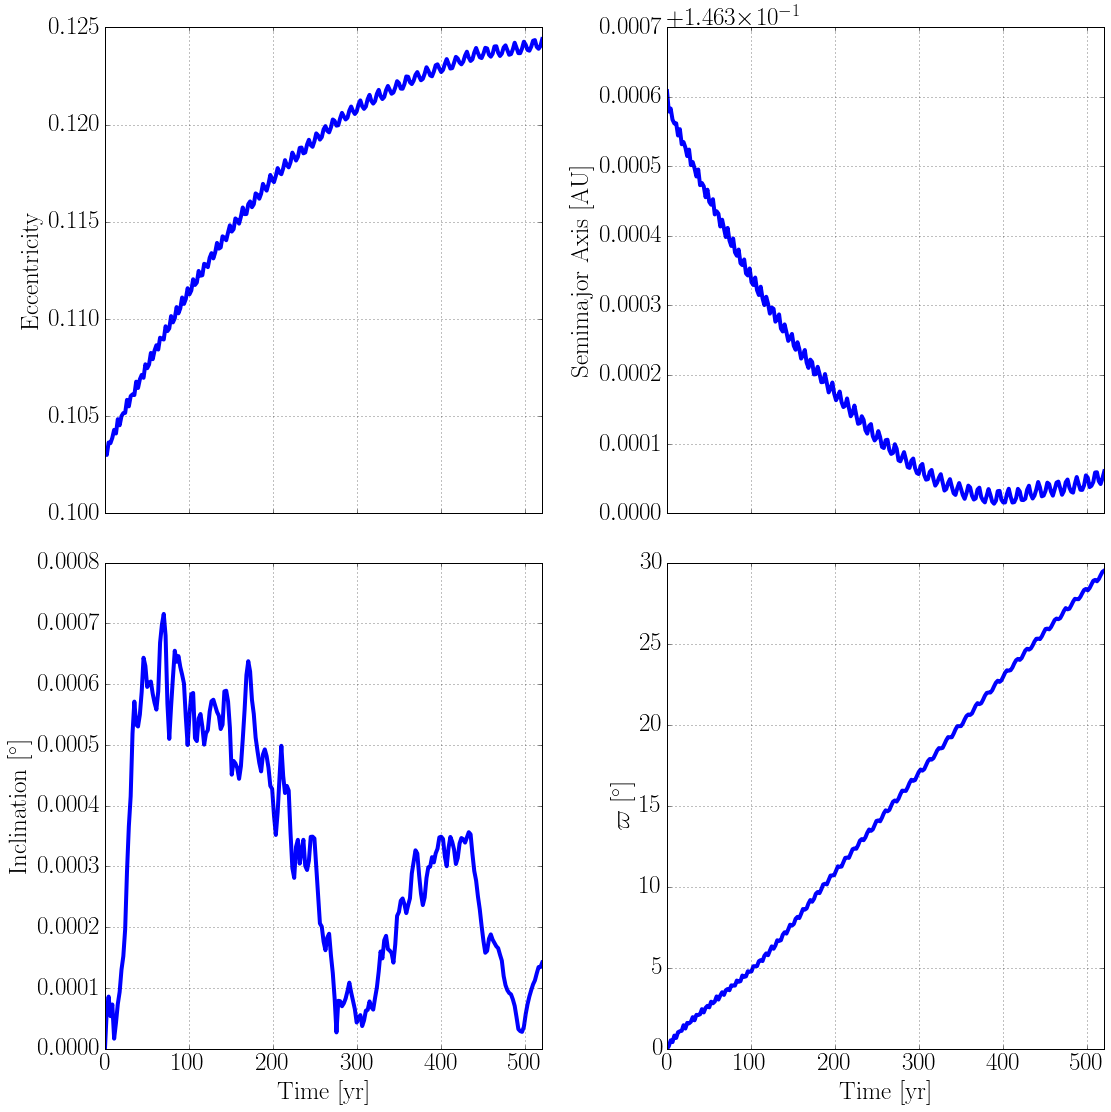

In [8]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(16,16), sharex=True)

# Top left, eccentricity
axes1[0,0].plot(time,orbElems[:,e],lw=4)
axes1[0,0].set_ylabel(r'Eccentricity')
axes1[0,0].grid(True)
axes1[0,0].set_xlim(time.min(),time.max())

# Top right, semimajor axis
axes1[0,1].plot(time,orbElems[:,a],lw=4)
axes1[0,1].set_ylabel(r"Semimajor Axis [AU]")
axes1[0,1].grid(True)
axes1[0,1].set_xlim(time.min(),time.max())

# Bottom left, inclination
axes1[1,0].plot(time,orbElems[:,inc],lw=4)
axes1[1,0].set_ylabel(r"Inclination [$^{\circ}$]")
axes1[1,0].set_xlabel(r"Time [yr]")
axes1[1,0].grid(True)
axes1[1,0].set_xlim(time.min(),time.max())

# Bottom right, varpi
# Compute varpi, correct range
varpi = orbElems[:,loan] + orbElems[:,w]

for i in range(0,len(varpi)):
    while varpi[i] > 360:
        varpi[i] = varpi[i] - 360.0
    while varpi[i] < 0:
        varpi[i] = varpi[i] + 360.0

axes1[1,1].plot(time,varpi,lw=4)
axes1[1,1].set_ylabel(r"$\varpi$ [$^{\circ}$]")
axes1[1,1].set_xlabel(r"Time [yr]")
axes1[1,1].grid(True)
axes1[1,1].set_xlim(time.min(),time.max())

# Clean up plot
fig1.tight_layout()

# Plot CBP orbital elements as a function of time

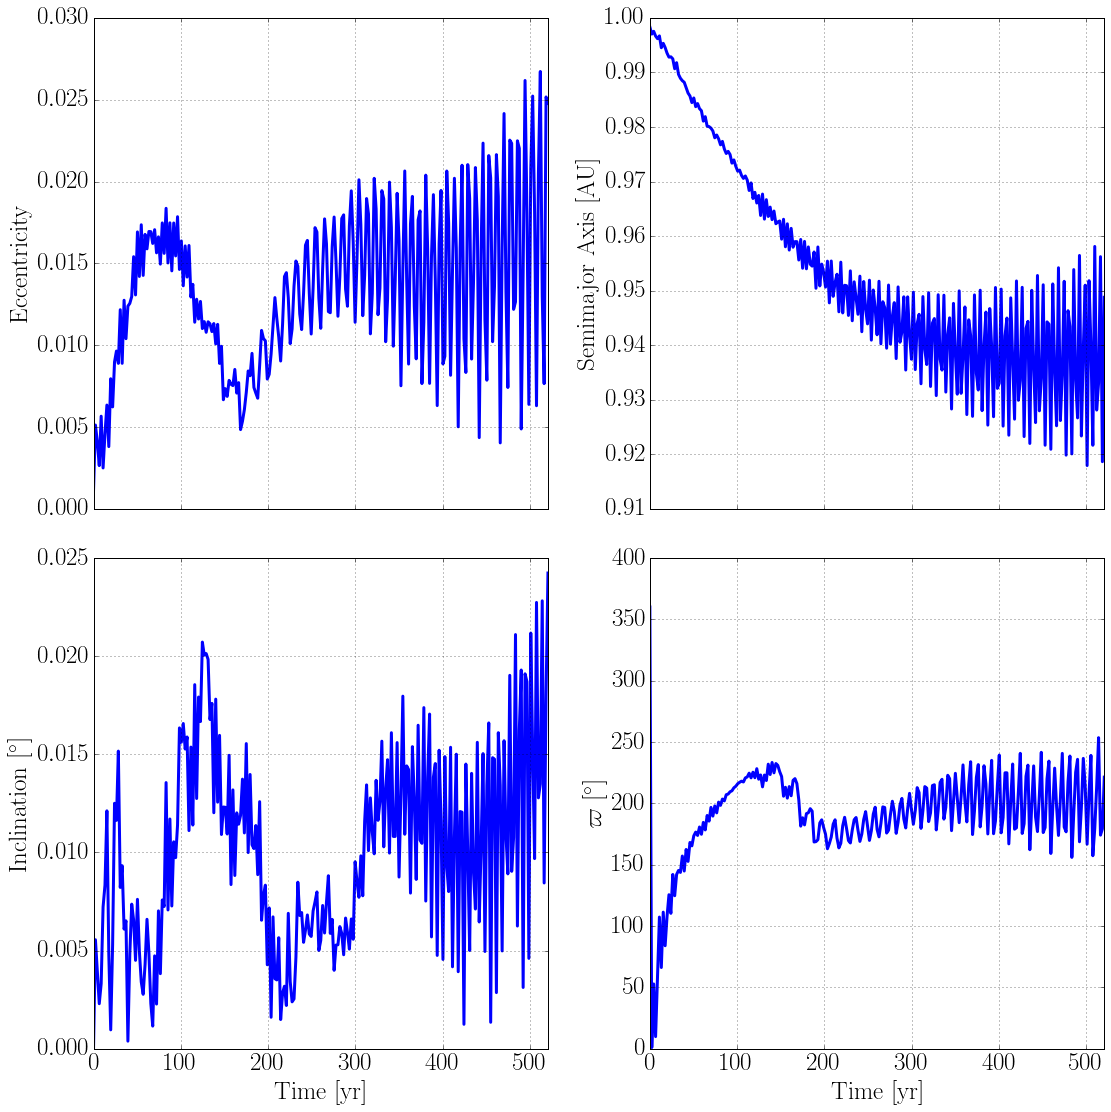

In [9]:
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(16,16), sharex=True)

# Top left, eccentricity
axes2[0,0].plot(time,cbpOrbElems[:,e],lw=3)
axes2[0,0].set_ylabel(r'Eccentricity')
axes2[0,0].grid(True)
axes2[0,0].set_xlim(time.min(),time.max())

# Top right, semimajor axis
axes2[0,1].plot(time,cbpOrbElems[:,a],lw=3)
axes2[0,1].set_ylabel(r"Semimajor Axis [AU]")
axes2[0,1].grid(True)
axes2[0,1].set_xlim(time.min(),time.max())

# Bottom left, inclination
axes2[1,0].plot(time,cbpOrbElems[:,inc],lw=3)
axes2[1,0].set_ylabel(r"Inclination [$^{\circ}$]")
axes2[1,0].set_xlabel(r"Time [yr]")
axes2[1,0].grid(True)
axes2[1,0].set_xlim(time.min(),time.max())

# Bottom right, varpi
# Compute varpi, correct range
varpi = cbpOrbElems[:,loan] + cbpOrbElems[:,w]

for i in range(0,len(varpi)):
    while varpi[i] > 360:
        varpi[i] = varpi[i] - 360.0
    while varpi[i] < 0:
        varpi[i] = varpi[i] + 360.0

axes2[1,1].plot(time,varpi,lw=3)
axes2[1,1].set_ylabel(r"$\varpi$ [$^{\circ}$]")
axes2[1,1].set_xlabel(r"Time [yr]")
axes2[1,1].grid(True)
axes2[1,1].set_xlim(time.min(),time.max())

# Clean up plot
fig2.tight_layout()

# Plot CBP, binary period ratio as a function of time to search for resonances

(0.0, 520.83455126822753)

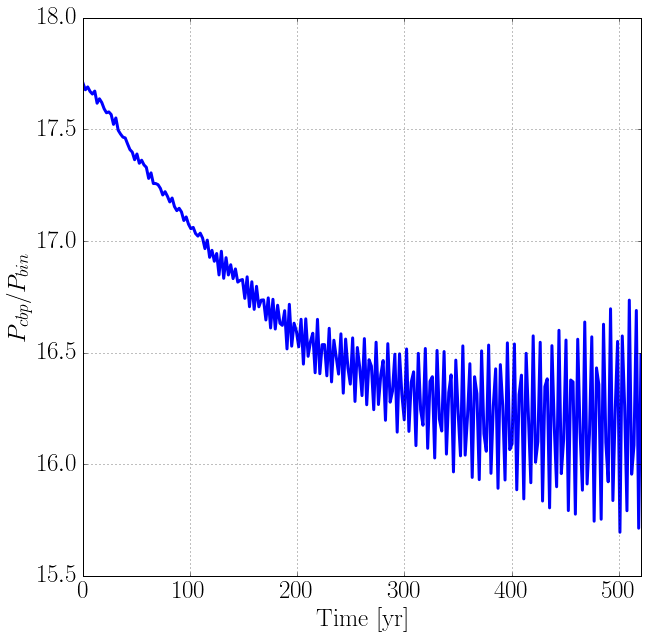

In [10]:
# First compute periods
binaryPeriod = AddBinary.aToP(a=orbElems[:,a], M=(binaryMass[:,0]+binaryMass[:,1]))
cbpPeriod = AddBinary.aToP(a=cbpOrbElems[:,a], M=(encDiskMass[:]+cbpMass[:]+binaryMass[:,0]+binaryMass[:,1]))

# Now plot!
fig3, ax3 = plt.subplots(figsize=(10,10))

ax3.plot(time,cbpPeriod/binaryPeriod,lw=3)
ax3.set_xlabel("Time [yr]")
ax3.set_ylabel("$P_{cbp}$/$P_{bin}$")
ax3.grid(True)
ax3.set_xlim(time.min(),time.max())

# Plot mass of binary, CBP, disk, disk enclosed mass as a function of time

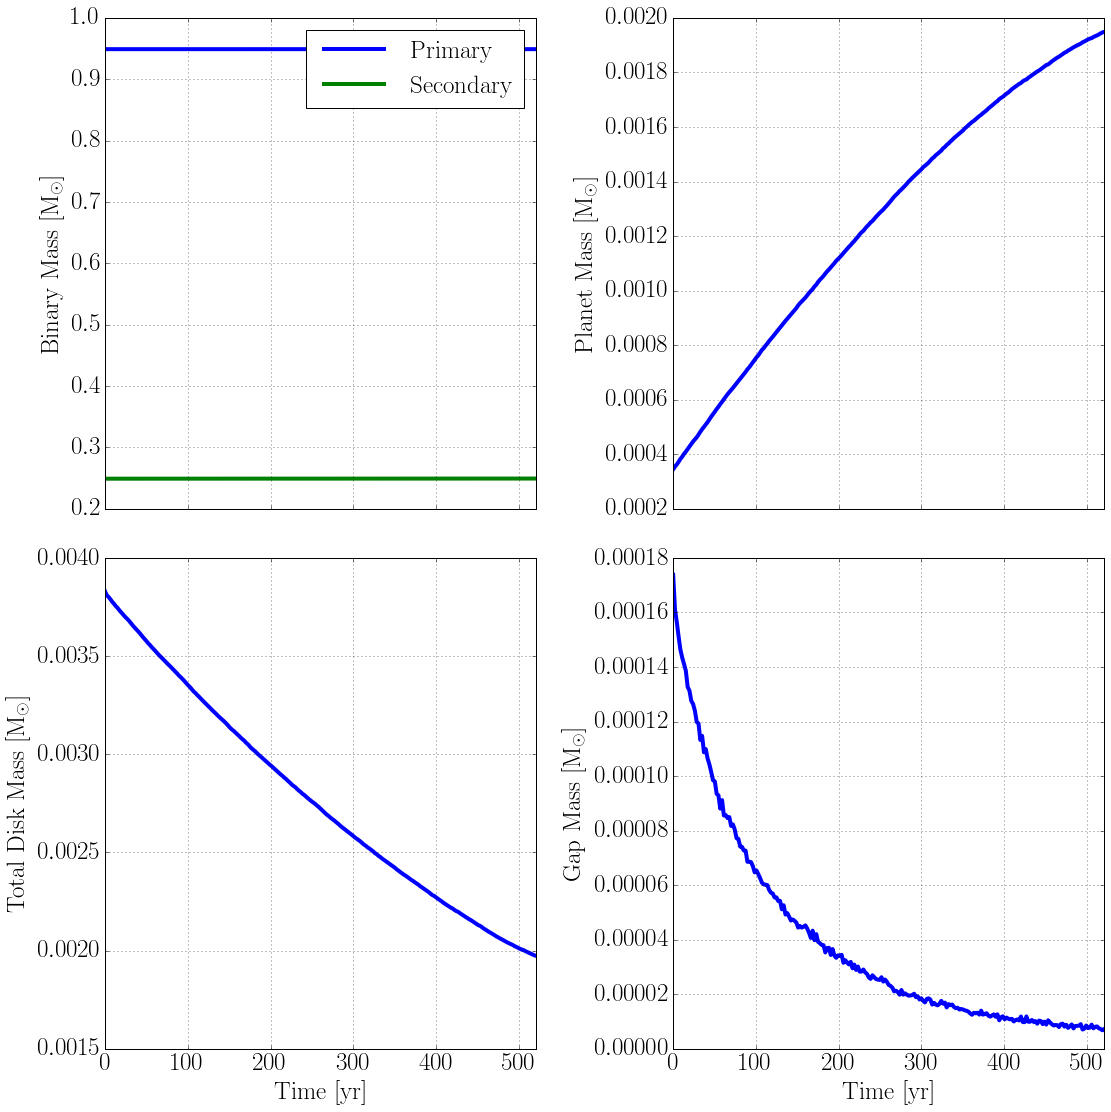

In [11]:
fig4, axes4 = plt.subplots(nrows=2, ncols=2, figsize=(16,16), sharex=True)

# Top left, binary mass
axes4[0,0].plot(time,binaryMass[:,0],lw=4,label=r"Primary")
axes4[0,0].plot(time,binaryMass[:,1],lw=4,label=r"Secondary")
axes4[0,0].set_ylabel(r'Binary Mass [M$_{\odot}$]')
axes4[0,0].legend()
axes4[0,0].grid(True)
axes4[0,0].set_xlim(time.min(),time.max())

# Top right, cbp mass
axes4[0,1].plot(time,cbpMass,lw=4)
axes4[0,1].set_ylabel(r"Planet Mass [M$_{\odot}$]")
axes4[0,1].grid(True)
axes4[0,1].set_xlim(time.min(),time.max())

# Bottom left, total disk mass
axes4[1,0].plot(time,diskMass,lw=4)
axes4[1,0].set_ylabel(r"Total Disk Mass [M$_{\odot}$]")
axes4[1,0].set_xlabel(r"Time [yr]")
axes4[1,0].grid(True)
axes4[1,0].set_xlim(time.min(),time.max())

# Bottom right, disk mass within cbp sink radius
axes4[1,1].plot(time,gapMass,lw=4)
axes4[1,1].set_ylabel(r"Gap Mass [M$_{\odot}$]")
axes4[1,1].set_xlabel(r"Time [yr]")
axes4[1,1].grid(True)
axes4[1,1].set_xlim(time.min(),time.max())

# Clean up plot
fig4.tight_layout()

# Plot the surface density profile for a few timesteps

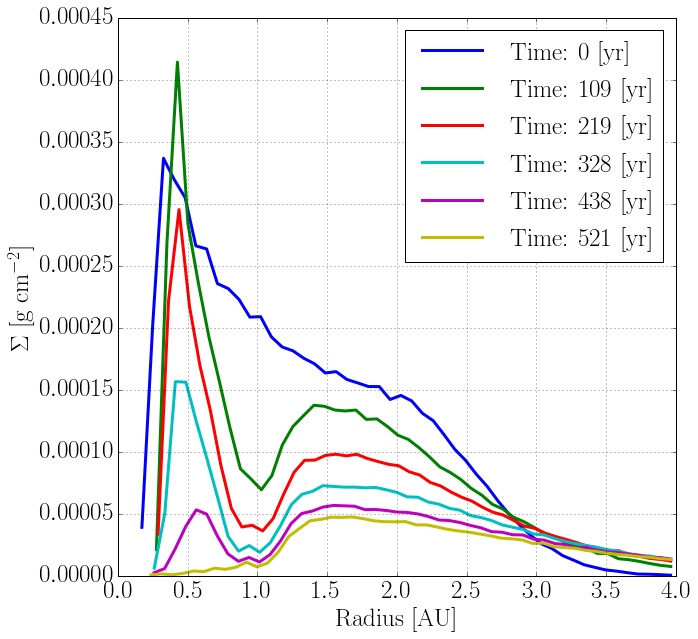

In [19]:
fig5, ax5 = plt.subplots(figsize=(10,10))

ind = [0,50,100,150,200,-1]

for val in ind:
    ax5.plot(radius[val,:],sigma[val,:],lw=3,label=r"Time: %.0lf [yr]" % time[val])
    
# Format plot
ax5.set_ylabel(r'$\Sigma$ [g cm$^{-2}$]')
ax5.set_xlabel(r"Radius [AU]")
ax5.legend()
ax5.grid(True)